### Purpose

1. Data expoloration for customer liftime value (CLV) prediction 

2. A quick RFM analysis with clustering 

3. Feature engineering for CLV


### Content and result

1. Extracting data from Postgre 


2. Checking missing value, exclude orders without customerID (24.9% missing)


3. Delete duplicated records


4. Data interrogating and validation 
   
   ( keep orders with negative value, keep all types of transaction (Normal sales, Return,Discount, Manual,Carriage,Postage and protection material,Bank charges). Delete 'return' transactions which have no previous transaction in the dataset )
   
   
5. Calulate 'Recency','Frequency' and 'Monetary' and score the values based on quartile values
   for clustering analysis
   

6. Cluster customers into 5 clusters using k-means (Elbow and Silhouette analysis)


7. Visualisation, analysis and summary
   
   Champions, Loyal/Potential Loyal, Promising, New Customers, About to Sleep/Churned
   

### Libraries:

1. psycopg2 
2. numpy,pandas,datetime,seaborn
3. mpl_toolkits,yellowbrick,sk-learn,plotly


### Data :

http://archive.ics.uci.edu/ml/datasets/Online+Retail


In [1]:
import warnings 
warnings.filterwarnings("ignore")


import numpy as np 
import pandas as pd 
import datetime as dt


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from mpl_toolkits import mplot3d


from yellowbrick.cluster import KElbowVisualizer
import plotly.graph_objects as go



%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
%matplotlib inline




### Dataset ( 541909 x 8 )

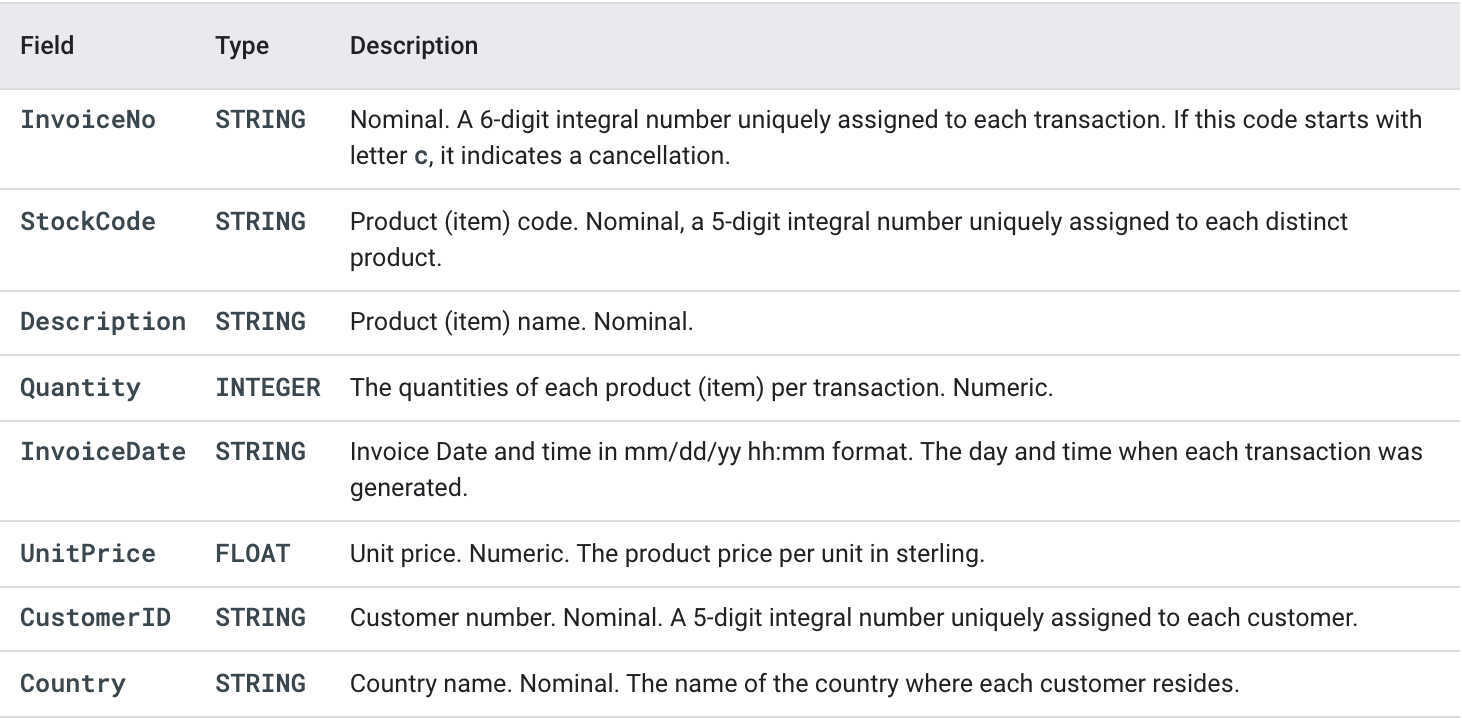

In [1]:
import psycopg2

# connect to database

conn = psycopg2.connect(
    host = 'localhost',
    database = 'OnlineRetail',
    user = 'postgres',
    password= '888888')

In [2]:
cur = conn.cursor()

In [3]:
cur.execute('select * from retail')
rows = cur.fetchall()
print('The number of rows:', cur.rowcount)

The number of rows: 541909


In [4]:
rows[0]

('536365',
 '85123A',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 6.0,
 datetime.date(2010, 12, 1),
 2.55,
 17850,
 'United Kingdom')

In [5]:
cur.close()
conn.close()

In [8]:
df_db = pd.DataFrame(data=rows, columns=['InvoiceNo','Stockcode','Description','Quantity','Date','Price','CustomerID','Country'])

In [9]:
df_db.to_csv('raw_from_db.csv', index=False)

In [2]:
df = pd.read_csv('raw_from_db.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   Stockcode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  float64
 4   Date         541909 non-null  object 
 5   Price        541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(3), object(5)
memory usage: 33.1+ MB


In [4]:
# Percentage of missing value
print('Percentage of missing value (%) \n ============= \n',df.isnull().sum()/df.shape[0]*100)

Percentage of missing value (%) 
 InvoiceNo       0.000000
Stockcode       0.000000
Description     0.268311
Quantity        0.000000
Date            0.000000
Price           0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


In [5]:
# check duplicated records
df.duplicated().sum() 

5269

# Why missingness?

check type of missingness using country and order date. 

It looks MCAR

In [6]:
# check type of missingness using country and order date

print('Related to country?:',df[df.CustomerID.isnull() == True].Country.unique())
print('Related to date:?',df[df.CustomerID.isnull() == True].Date.unique().shape[0])

Related to country?: ['United Kingdom' 'EIRE' 'Bahrain' 'Israel' 'Hong Kong' 'Unspecified'
 'France' 'Switzerland' 'Portugal']
Related to date:? 277


In [7]:
retail = df.copy(deep = True)

In [8]:
# Drop missing value in 'CustomerID'
retail = retail.dropna(subset=['CustomerID'])
retail = retail.drop_duplicates()

In [9]:
retail.CustomerID = retail.CustomerID.astype('int')
retail.CustomerID = retail.CustomerID.astype('str')
retail['Quantity'] = retail.Quantity.astype('int')
retail.Date = pd.to_datetime(retail.Date)

In [10]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401603 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401603 non-null  object        
 1   Stockcode    401603 non-null  object        
 2   Description  401603 non-null  object        
 3   Quantity     401603 non-null  int64         
 4   Date         401603 non-null  datetime64[ns]
 5   Price        401603 non-null  float64       
 6   CustomerID   401603 non-null  object        
 7   Country      401603 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB


In [11]:
# summary non-numerical columns
retail.describe(include=[object])

InvoiceNo Stockcode                         Description CustomerID  \
count     401603    401603                              401603     401603   
unique     22190      3684                                3896       4372   
top       576339    85123A  WHITE HANGING HEART T-LIGHT HOLDER      17841   
freq         542      2065                                2058       7812   

               Country  
count           401603  
unique              37  
top     United Kingdom  
freq            356727

In [12]:
# summary numerical columns
retail[['Quantity','Price']].describe()

Quantity          Price
count  401603.000000  401603.000000
mean       12.183298       3.474067
std       250.283348      69.764122
min    -80995.000000       0.000000
25%         2.000000       1.250000
50%         5.000000       1.950000
75%        12.000000       3.750000
max     80995.000000   38970.000000

# Why does quantity have negative value? 

Cannot assume they are mistakes.

Negative quantity means returned items

Check if a customer having a negative quantity for items has bought the same item within a short period.

Apparently, InvoiceNO starts with "C" means returned items.

In [13]:
# Negative quantity is returned items

ndf = retail.loc[retail.Quantity <= 0,:]
ndf.tail(10)

InvoiceNo Stockcode                       Description  Quantity  \
540141   C581468     21314     SMALL GLASS HEART TRINKET POT       -10   
540142   C581468     22098         BOUDOIR SQUARE TISSUE BOX       -12   
540176   C581470     23084                RABBIT NIGHT LIGHT        -4   
540422   C581484     23843       PAPER CRAFT , LITTLE BIRDIE    -80995   
540448   C581490     22178   VICTORIAN GLASS HANGING T-LIGHT       -12   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

             Date   Price CustomerID         Country  
540141 2011-12-08    2.10      13599  United Kingdom  
540142 2011-12-08    0.39      13599  United Kingdom  
540176 2011-12-08    2.08      17924  United Kingdom  
540422 2011-12-09    2.08      16446  United Kingdom  
540448 2011-12-09    1.95      14397  United Kingdom  
540449 2011-12-09    0.83      14397  United Kingdom  
541541 2011-12-09  224.69      15498  United Kingdom  
541715 2011-12-09   10.95      15311  United Kingdom  
541716 2011-12-09    1.25      17315  United Kingdom  
541717 2011-12-09    1.25      17315  United Kingdom

In [14]:
customer_id = ndf.tail(10).CustomerID.unique().tolist()
item = ndf.tail(10).loc[ndf.CustomerID == customer_id[0],'Stockcode'].tolist()
temp = retail.loc[retail.CustomerID == customer_id[0],:]
temp.loc[temp.Stockcode==item[0],:]

InvoiceNo Stockcode                    Description  Quantity  \
106434    545322     21314  SMALL GLASS HEART TRINKET POT        48   
508724    579262     21314  SMALL GLASS HEART TRINKET POT        48   
540141   C581468     21314  SMALL GLASS HEART TRINKET POT       -10   

             Date  Price CustomerID         Country  
106434 2011-03-01   1.85      13599  United Kingdom  
508724 2011-11-29   1.85      13599  United Kingdom  
540141 2011-12-08   2.10      13599  United Kingdom

  # What's in the transaction record?
 
 1. Normal items with length of stockcode 5,6,7
 
 2. Discount, Manual 
 
 3. Carriage 
 
 4. Postage and protection material 
 
 5. Bank charges
 
### Should discount, maual, carriage, postage ... been included? 

In [15]:
print('Percentage of each type of transaction :\n', retail.Stockcode.apply(len).value_counts(normalize=True))

Percentage of each type of transaction :
 5     0.911791
6     0.082704
4     0.003028
1     0.001337
7     0.000737
2     0.000334
3     0.000040
12    0.000030
Name: Stockcode, dtype: float64


In [16]:
# what other type of transaction in the record
for i in [1,2,3,4,12]:
    
    print(retail.loc[retail.Stockcode.apply(len) == i,:]
          .Description.unique())

['Discount' 'Manual']
['CARRIAGE']
['DOTCOM POSTAGE']
['POSTAGE' 'PADS TO MATCH ALL CUSHIONS' 'CRUK Commission']
['Bank Charges']


# RFM analysis for clustering and feature engineering 
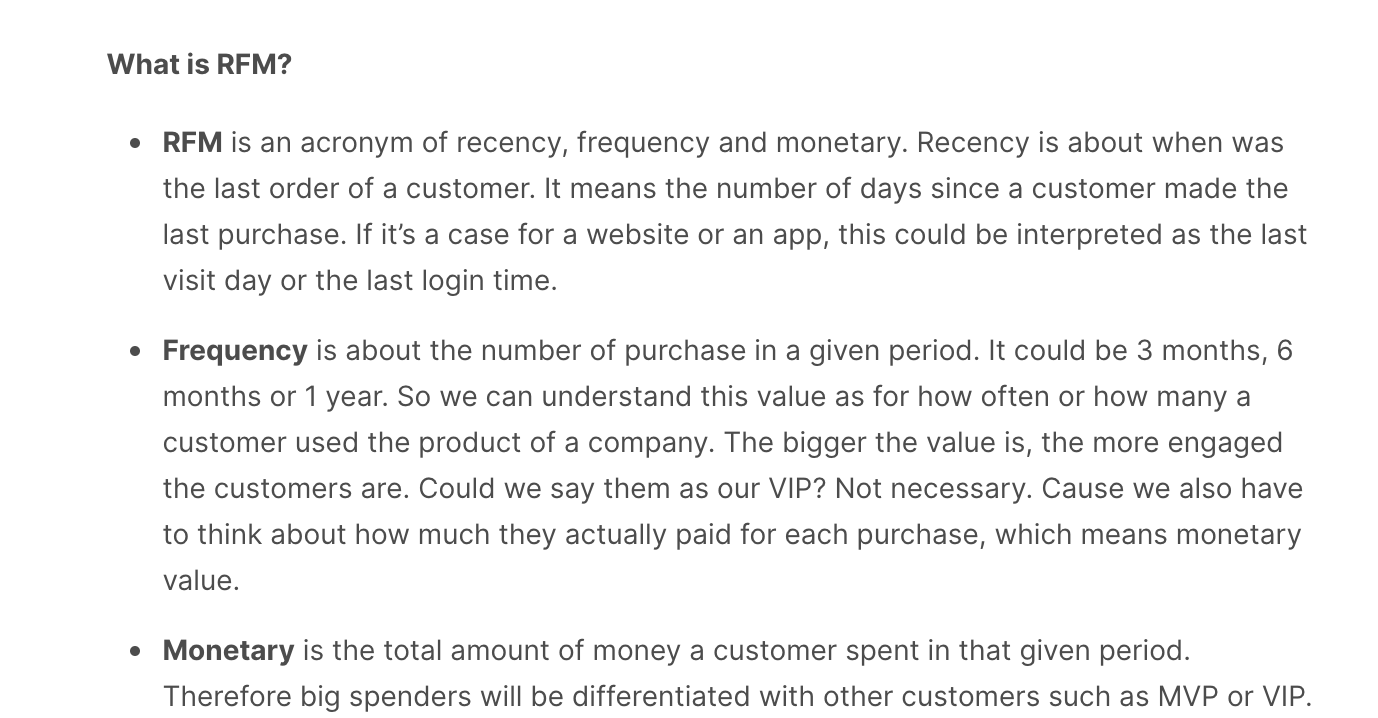
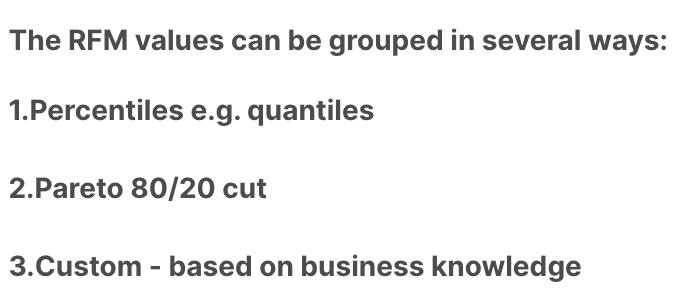


### Here, RFM will be scored by quartile

In [17]:
# total value for each transaction

retail['Totalvalue'] = retail['Price']* retail['Quantity']

retail.Totalvalue.describe()

count    401603.000000
mean         20.613679
std         430.352753
min     -168469.600000
25%           4.250000
50%          11.700000
75%          19.800000
max      168469.600000
Name: Totalvalue, dtype: float64

In [18]:
# assume this analysis is done the next day of the last transaction day

anal_date = retail['Date'].max() + dt.timedelta(days = 1)
anal_date

Timestamp('2011-12-10 00:00:00')

In [19]:
Recency = retail.groupby(['CustomerID']).agg({'Date': lambda x: (anal_date - x.max()).days}) 

Frequency = retail.groupby(['CustomerID']).Date.nunique()

Moneytaryvalue= retail.groupby(['CustomerID']).agg({'Totalvalue':'sum'})

In [20]:
rfm = pd.concat([Recency,Frequency,Moneytaryvalue],axis=1)
rfm.columns = ['Recency','Frequency','Moneytaryvalue']

In [21]:
rfm.head()

Recency  Frequency  Moneytaryvalue
CustomerID                                    
12346           326          1            0.00
12347             3          7         4310.00
12348            76          4         1797.24
12349            19          1         1757.55
12350           311          1          334.40

In [22]:
# Label RFM value

# for recentcy, the larger the value is the lower the score is 
r_labels =range(4,0,-1)
f_labels = range(1,5)
m_labels=range(1,5)

rfm['Rscore'] = pd.qcut(rfm['Recency'], q=4, labels = r_labels)
# rfm['Fscore'] = pd.cut(rfm['Frequency'],[1,2,7,11,19,147],include_lowest=True,labels=f_labels)
rfm['Fscore'] = pd.qcut(rfm['Frequency'],q=5,duplicates='drop',labels=f_labels)
rfm['Mscore'] = pd.qcut(rfm['Moneytaryvalue'],q=4,labels = m_labels)


# add RFM Score

def add_label(x) : 
    return str(x['Rscore']) + str(x['Fscore']) + str(x['Mscore'])
rfm['Label'] = rfm.apply(add_label,axis=1 )
rfm['Score'] = rfm[['Rscore','Fscore','Mscore']].sum(axis=1)

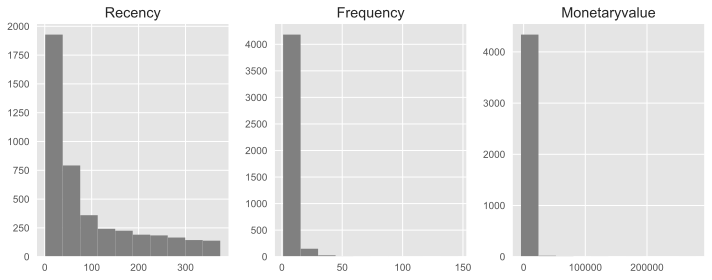

In [25]:
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(1,3,figsize=(10, 4))
plt.subplot(1,3,1)
plt.hist(rfm['Recency'], color='grey')
plt.title('Recency')
plt.subplot(1,3,2)
plt.hist(rfm['Frequency'],color='grey')
plt.title('Frequency')
plt.subplot(1,3,3)
plt.hist(rfm['Moneytaryvalue'],color='grey')
plt.title('Monetaryvalue')
# plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

### Extremely skewed data, maybe better to rank the value ( score)

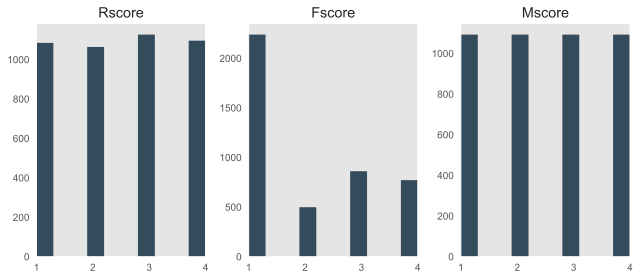

In [26]:
fig,ax = plt.subplots(1,3,figsize=(9,4))

cols = ['Rscore','Fscore','Mscore']
for i in range(1,4):
    
    plt.subplot(1,3,i)
    plt.hist(rfm[cols[i-1]],color=sns.color_palette('Blues_d')[5])
    plt.title(cols[i-1])
    plt.xlim((1,4))

    plt.xticks([1,2,3,4])
    plt.grid(False)
    plt.tight_layout()


# Clustering base on score


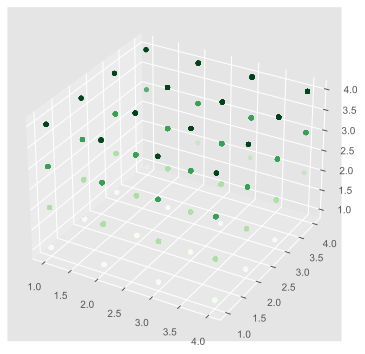

In [27]:
features = ['Rscore','Fscore','Mscore']
df_score = rfm[features]

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,9))
ax = plt.axes(projection='3d')


ax.scatter3D(df_score['Rscore'], df_score['Fscore'], df_score['Mscore'], c=df_score['Mscore'], cmap='Greens')

### Not a good way to display ordinal data 

### k-means

In [28]:
scale=StandardScaler()
data=scale.fit_transform(df_score)
data_df=pd.DataFrame(data,columns=features)
data_df.head()

Rscore    Fscore    Mscore
0 -1.352764 -0.873039 -1.341641
1  1.333105  1.649715  1.341641
2 -0.457474  0.808797  1.341641
3  0.437816 -0.873039  1.341641
4 -1.352764 -0.873039 -0.447214

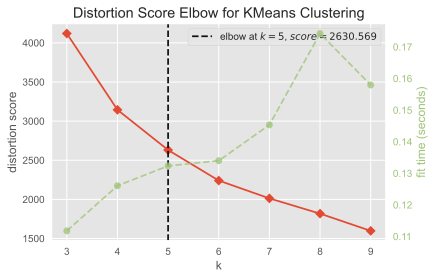

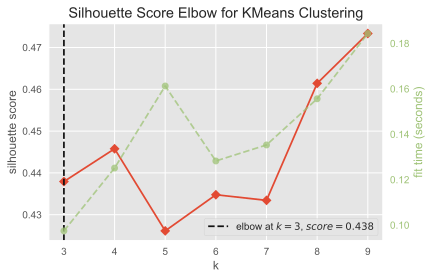

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [55]:


clusterer = KMeans(init='k-means++',n_init=20, max_iter=100, random_state=42)
visualizer1 = KElbowVisualizer(clusterer, k=(3, 10), metric='distortion') 

visualizer1.fit(data_df)
visualizer1.show()

visualizer2 = KElbowVisualizer(clusterer, k=(3, 10), metric='silhouette') #silhouette

visualizer2.fit(data_df)
visualizer2.show()




For n_cluster= 4 The silhouette score is: 0.44577544315106704
For n_cluster= 5 The silhouette score is: 0.4261394842011021
For n_cluster= 6 The silhouette score is: 0.4347779277283912
For n_cluster= 7 The silhouette score is: 0.4334370745805342
For n_cluster= 8 The silhouette score is: 0.4614193675275055
For n_cluster= 9 The silhouette score is: 0.47333732480578766


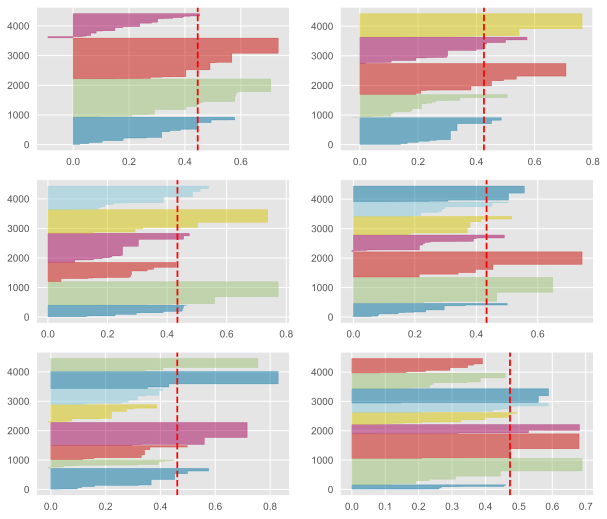

In [56]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

fig, ax = plt.subplots(3, 2, figsize=(10,9))
for i in [4,5,6,7,8,9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=20, max_iter=200, random_state=42)
   
    
    q, mod = divmod(i-2, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_df)
    print('For n_cluster=',i,
         'The silhouette score is:',visualizer.silhouette_score_)

### Number of clusters
 According to the elbow, 4-9 could be considered since the scores don't have significant difference. Further silhouette analysis shows 5,6 clusters may be better, because score of each cluster is equal or larger than average line and without negative value (e,g. 4 clusters and 7 clusters). More important, the number of clusters also depends on if it makes more sence or makes better interpretation when thinking about the business itself.

In [29]:
# Fit the data with number of clusters 5 and 6

clusterer = KMeans(n_clusters=5,init='k-means++', n_init=10, max_iter=100,random_state=42)
# clusterer = KMeans(n_clusters=5)
clusters = clusterer.fit_predict(data_df)
# markers = list('*hH+xXDd|.,ov^<>12348spP')

# for cluster in np.unique(clusters):
#     cluster_data = data_df[clusters==cluster]
#     plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], alpha=0.7, marker=markers[cluster])

In [30]:
data_df['Cluster'] = clusters
data_df.head()



Rscore    Fscore    Mscore  Cluster
0 -1.352764 -0.873039 -1.341641        1
1  1.333105  1.649715  1.341641        0
2 -0.457474  0.808797  1.341641        3
3  0.437816 -0.873039  1.341641        3
4 -1.352764 -0.873039 -0.447214        2

In [31]:
data_df.groupby(['Cluster'])[['Rscore','Fscore','Mscore']].median().sort_values(by=['Rscore','Fscore','Mscore'])


Rscore    Fscore    Mscore
Cluster                              
1       -1.352764 -0.873039 -1.341641
2       -1.352764 -0.873039 -0.447214
3       -0.457474  0.808797  0.447214
4        0.437816 -0.873039 -0.447214
0        1.333105  1.649715  1.341641

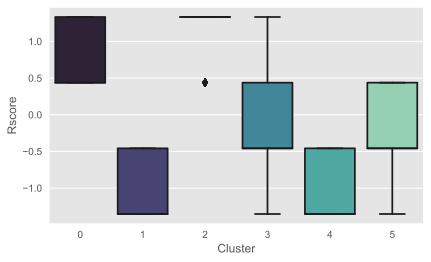

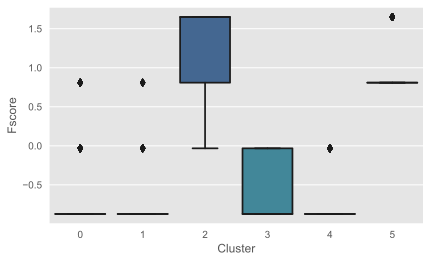

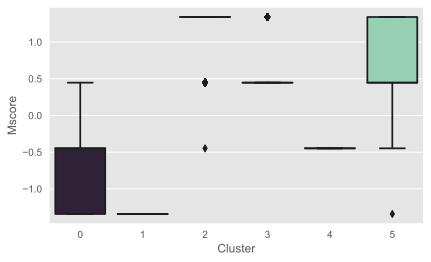

In [550]:
# sns.color_palette("mako", as_cmap=True)
# cate_list = ['Rscore','Fscore','Mscore']
# fig,axes= plt.subplots (1,3, figsize= (6,4))
# for ax,score in zip(axes,cate_list):
    
# for i in range(0,len(cate_list)):
#     primary_cat = cate_list[i]
   
#     fig = sns.boxplot(data= data_df, x ='Cluster', y=primary_cat,palette='mako',
# #                 order= df[primary_cat].value_counts().iloc[:10].index,
#                        )

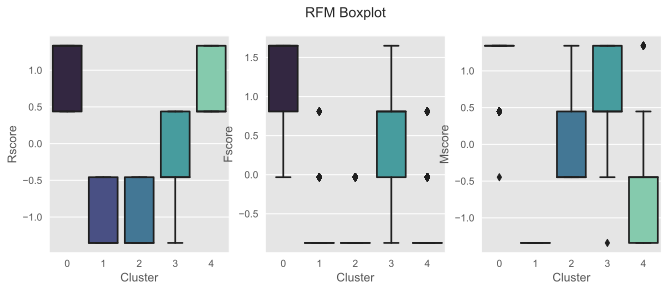

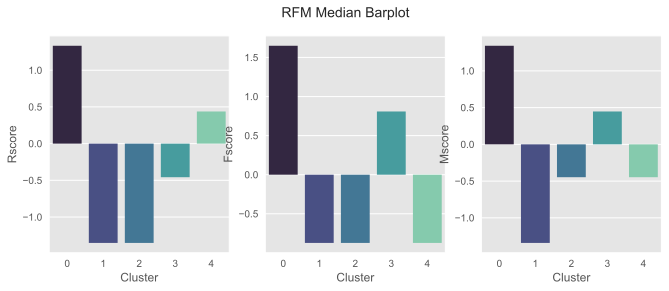

In [32]:
cate_list = ['Rscore','Fscore','Mscore']
fig,axes= plt.subplots (1,3, figsize= (11,4))

for ax,score in zip(axes,cate_list):
#     medianprops = dict(linestyle='-.', linewidth=2.5, color='yellow')
    sns.boxplot(data= data_df, x ='Cluster', y=score,palette='mako',ax=ax, 
                #,medianprops = medianprops

               )
fig.suptitle('RFM Boxplot',fontsize = 14)    
plt.show()



medians = data_df.groupby(['Cluster'])[['Rscore','Fscore','Mscore']].median()   
fig,axes= plt.subplots (1,3, figsize= (11,4))
for ax,score in zip(axes,cate_list):
    
    sns.barplot(data=medians, x=medians.index, y=score,palette='mako',ax=ax)
    
fig.suptitle('RFM Median Barplot',fontsize = 14) 
plt.show()

# Clustering analysis based on RFM ( customer segmentation)

###      Segmantation by 5 clusters is better than by 6 clusters in terms of interpretation

1. Champions: high recency, high frequency,high moneytary value (cluster 0)
   
2. Loyal/potencially loyal: good moneytary value, high frequency (cluster 3)

3. promising: low frenquency, good moneytary value (cluster 2)

4. new customer: high recency, low frenquency (cluster 4)

5. About to sleep or churned: all low (cluster 1)


In [33]:
data_df.set_index(rfm.index, inplace= True)
# pd.concat([rfm, data_df.Cluster],axis=1)

In [36]:
# final_df = pd.concat([rfm, data_df.Cluster],axis=1)
final_df.to_csv('clustering_dataframe.csv')

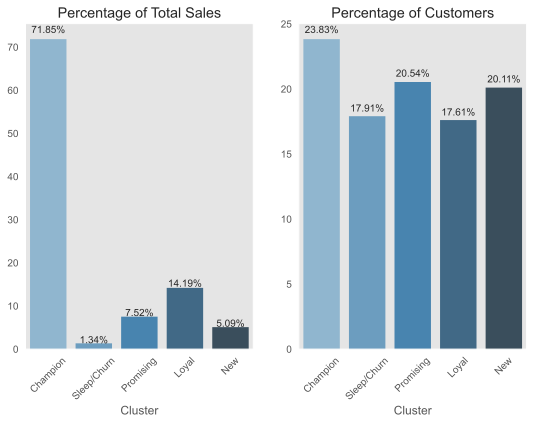

In [42]:
# Aggregation


cluster_list = ['Champion','Sleep/Churn','Promising','Loyal','New']
# Total Moneytary Value for each cluster
TotalSales = final_df.groupby(['Cluster']).Moneytaryvalue.sum()
PercentTotalSales = TotalSales/sum(TotalSales)*100


# No. of customers for each cluster
NumberofCustomers = final_df.groupby(['Cluster']).Fscore.count()
PercentofCustomers = NumberofCustomers /sum(NumberofCustomers)*100
plt.subplots(1,2, figsize = (9,6))

# Draw barplot
plt.subplot(1,2,1)
ax1 = sns.barplot(x = PercentTotalSales.index,y = PercentTotalSales,palette='Blues_d')
plt.title('Percentage of Total Sales')
plt.grid(False)
plt.xticks(ticks=PercentTotalSales.index,labels=cluster_list,rotation = 45)
plt.ylabel('')
for i,p in enumerate(ax1.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    plt.text(x + width/2, y + height*1.02,str(np.round(PercentTotalSales[i],2))+'%', ha='center')

plt.subplot(1,2,2)
ax2 = sns.barplot(x = PercentofCustomers.index,y = PercentofCustomers,palette='Blues_d')
plt.title('Percentage of Customers')
plt.xticks(ticks=PercentofCustomers.index,labels=cluster_list,rotation = 45)
plt.grid(False)
plt.ylabel('')
for i,p in enumerate(ax2.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    plt.text(x + width/2, y + height*1.02,str(np.round(PercentofCustomers[i],2))+'%', ha='center')    




In [50]:
agg = pd.concat([PercentTotalSales,PercentofCustomers],axis=1)
agg = agg.reset_index()
agg.columns = ['Cluster','PercentTotalSales','PercentCustomers']
agg.to_csv('agg.csv',index = False)

In [43]:
clusters = data_df.Cluster
df_normalized =data_df.copy(deep=True)
df_normalized[features] /= data_df[features].max()


biggest_cluster = data_df.groupby(['Cluster']).count().max().max()

In [44]:
import plotly.graph_objects as go

fig = go.Figure()

for cluster in np.unique(clusters):
    
    radii = df_normalized.loc[df_normalized.Cluster==cluster, features].median().tolist()
    thetas = features
    
    actual_values = data_df.loc[data_df.Cluster==cluster, features].median().tolist()
    cluster_size = len(data_df[data_df.Cluster==cluster])
    print('Size of cluster {}: {}'.format(cluster,cluster_size))
    fig.add_trace(
        go.Scatterpolar(
            r=radii + radii[:1],
            theta=thetas + thetas[:1],
            mode='lines',
            name=f'Cluster {cluster}',
            text = [f'Mean value: {x}' for x in actual_values + actual_values[:1]],
            line=dict(width=3),
            opacity=np.max([cluster_size/biggest_cluster*0.6, 0.6])
        )
    )

fig.update_layout(
    title='Clustering Analysis',
    showlegend=True,
    template='plotly_dark',
    width=1000,
    autosize=False
)

fig.show()

Size of cluster 0: 1042
Size of cluster 1: 783
Size of cluster 2: 898
Size of cluster 3: 770
Size of cluster 4: 879


# Summary on RFM and Recommendation

1. Champions: high recency, high frequency,high moneytary value (cluster 0)

   Champion customers is 23.83% of the total, but disproportionately generated 71.85% revenue. Thus reward them and focusing on keeping them happy should be a top priority. Action could be further analyzing their individual preferences and affinities which will provide additional opportunities for even more personalized messaging. They can be early adopters for new products. Communications with this group should make them feel valued and appreciated.

   
2. Loyal/potencially loyal: good moneytary value, high frequency (cluster 3)
   
   These repeat customers are active and loyal, but they are low spenders. Marketers should create campaigns for this group that make them feel valued, and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks.
   

3. Promising: high recency, low frenquency, good moneytary value (cluster 2)

   It is possible to develop loyalists, for example branding and offer free trials. Action maybe similar with loyal customers. They may either churn or become loyal depending on if action been taken. 
   

4. New customer: high recency, low frenquency (cluster 4)

   Hight percentage of customers, good chance to improve sales by building relationship, provide on-boarding customer support. For new customers who spend a lot on their first purchase, it’s even more important. Like with the champion group, it’s important to make them feel valued and appreciated – and to give them terrific incentives to continue interacting with the brand.
   

5. About to sleep or churned: all low (cluster 1)

   Try to reach out campaign or ignore base on response. These are customers who stopped transacting a long time ago. While it’s often challenging to re-engage churned customers, the high response rate (predicted) of these customers makes it worthwhile trying. It’s important to communicate with them on the basis of their specific preferences, as known from earlier transaction data.